# Comparing Logistic Regression against Pairwise Logistic Regression

We have 4 cohorts in our dataset and we want to find the KEGGs that discriminate between them. We visualize the KEGG distributions with heatmaps organized by hierarchical clustering. The dataest has 63 subjects and ~10K KEGGs.

**Part 1: Logistic Regression with Lasso Penalty**

We use Logistic Regressiong with Lasso Penalty. This is a classic model that yields sparse solutions; that is we find the sparse set of important KEGGs. We select the Lasso Penatly weight using cross validation as is typically done.  

In this case the dataset has 63 rows and ~10K columns

**Part 2: Pairwise Comparison between cohorts using Logistic Regression with Lasso Penalty**

We prepare the data by computing pairwise comparisons between the different subjects then apply binary Logistic Regression with Lasso Penalty on whether a pair of samples belong in the same group. The KEGGs that distinguish the different groups are then considered important.

In this case the dataset has *1953 rows* and ~10K columns. We posit since there are more rows the data is better regularized and will yield a sparser set compared to the set of KEGGs found in Part 1 above. 


In [1]:
import pandas as pd
import numpy as np

import itertools
from sklearn.linear_model import LogisticRegressionCV

import matplotlib.pylab as plt
import seaborn as sns;
%matplotlib inline

# Data Prep

In [2]:
df = pd.read_csv("../../data/keggs-subjects-rf-scores.csv")

df.head()

,kegg,over.abundant.health.conf,LS001,LS002,LS003,LS004,LS005,LS006,LS007,CD.SRS301865,...,HE.SRS016335,HE.SRS016495,HE.SRS017103,HE.SRS017433,HE.SRS018427,HE.SRS018656,HE.SRS020328,HE.SRS020869,HE.SRS022713,HE.SRS016585.suspect
0,K00001(alcohol_dehydrogenase),0.366,0.005732,0.006140,0.006243,0.005962,0.008011,0.004744,0.005444,0.005043,...,0.002705,0.005025,0.003359,0.004281,0.003052,0.003625,0.002673,0.003999,0.003734,8.220359e-03
1,K00002(alcohol_dehydrogenase_(NADP+)),0.312,0.000382,0.000409,0.000610,0.000533,0.000313,0.000412,0.000390,0.001005,...,0.000461,0.000255,0.000071,0.000014,0.000248,0.000649,0.000151,0.000157,0.000000,4.812945e-07
2,K00003(homoserine_dehydrogenase),0.310,0.000855,0.001034,0.001125,0.001074,0.001224,0.000721,0.000786,0.001025,...,0.000195,0.001063,0.000249,0.000131,0.000351,0.000676,0.000430,0.000318,0.000050,1.209999e-06
3,"K00004((R,R)-butanediol_dehydrogenase_/_diacet...",0.192,0.000091,0.000106,0.000149,0.000116,0.000064,0.000084,0.000080,0.000016,...,0.000006,0.000025,0.000008,0.000008,0.000014,0.000039,0.000068,0.000010,0.000006,4.127393e-04
4,K00005(glycerol_dehydrogenase),0.004,0.000167,0.000236,0.000223,0.000203,0.000218,0.000144,0.000143,0.000166,...,0.000012,0.000427,0.000030,0.000004,0.000034,0.000036,0.000055,0.000065,0.000000,2.158647e-04


In [3]:
X = df.iloc[:,2:].values
np.min(X[X>0])

3.1125837891788104e-09

In [4]:
laplace_scale = 1e-9

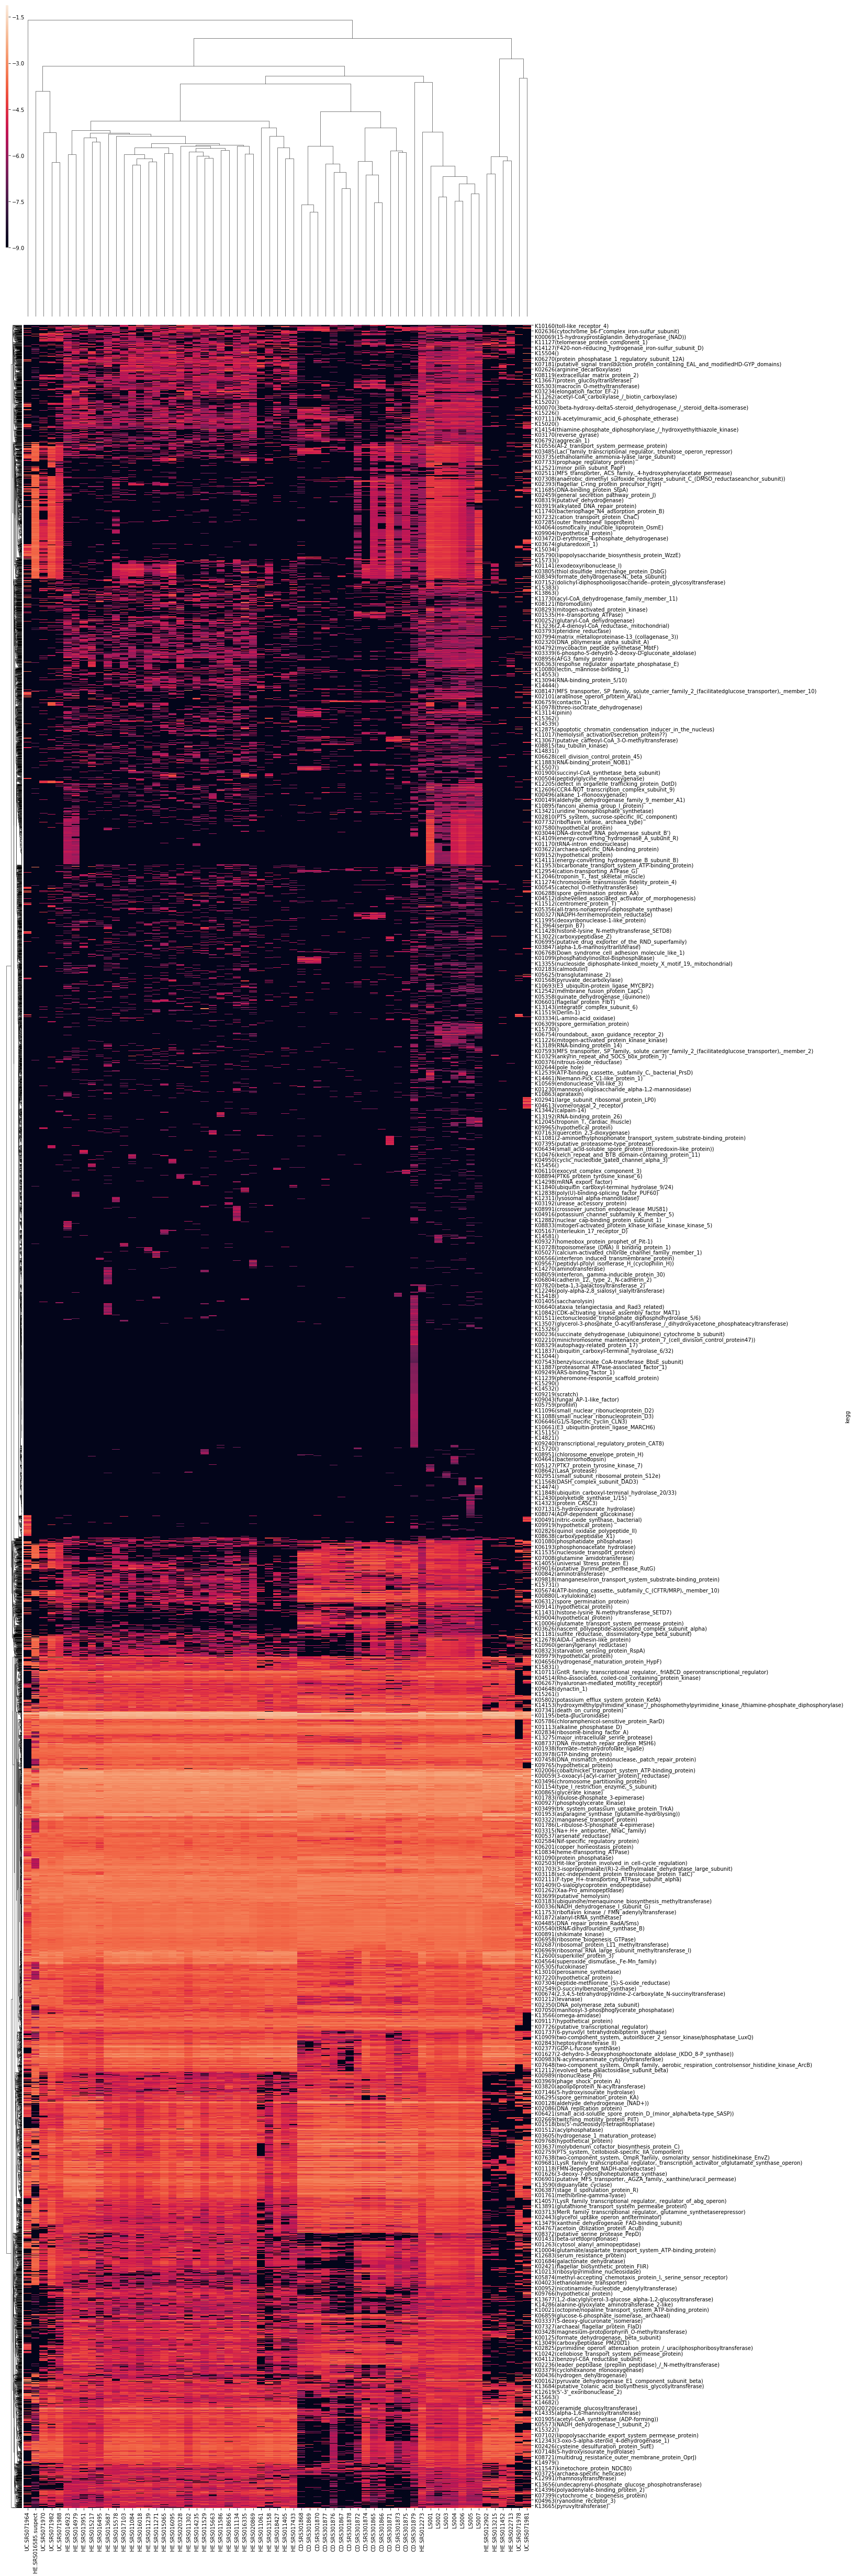

In [5]:
df.index = df.kegg

sns.clustermap(np.log10(laplace_scale+df.iloc[:,2:]),figsize=(18, 88));

Above we show the clustered heatmap of the entire dataset. There is a lot of structure in the data but a lot of KEGGs actually confuse the hierarchical clustering algorithm and hence we observe that some subjects are grouped together when they in fact they do not belong together (for example the 4 HE and 2 UC subjects in the far right). 

There are many explanations for this, one being the "curse of dimensionality" - the clustering algortihm uses euclidean distance (which is an accceptable distance metric to use on log-transformed data), however distances become harder to distnguish in higher dimensions. Hence, it is harder to distinguish different cohorts with more KEGGs.

# Part 1: Lasso Logistic Regression

We use Logistic Regression with lasso penalty to find the important KEGGs. We use Lasso since the Lasso yields sparse solutions. The weight for lasso penalty is select with cross validation. 

In [6]:
X = df.iloc[:,2:].values.T

y = np.zeros(X.shape[0]) # 0 is healthy

y[np.where(df.iloc[:, 2:].columns.str.contains("LS"))[0]] = 1 # 1 is LS
y[np.where(df.iloc[:, 2:].columns.str.contains("CD"))[0]] = 2 # 2 is CD
y[np.where(df.iloc[:, 2:].columns.str.contains("UC"))[0]] = 3 # 3 is UC

In [7]:
%%time 
LR = LogisticRegressionCV(Cs = np.logspace(-4, 2, 100), penalty="l1", n_jobs=-2, 
                          class_weight='balanced', solver = "liblinear")

LR.fit(np.log10(laplace_scale + X), y)

CPU times: user 714 ms, sys: 439 ms, total: 1.15 s
Wall time: 17.4 s


In [8]:
LR.C_

array([0.12328467, 3.51119173, 1.7475284 , 9.32603347])

Since we have 4 cohorts and Lasso Logistic Regression is for binary regression, we build 4 logistic regression models for each cohort. Below we plot the distribution of the KEGG weights for each of these models that are built with respect to each cohort.

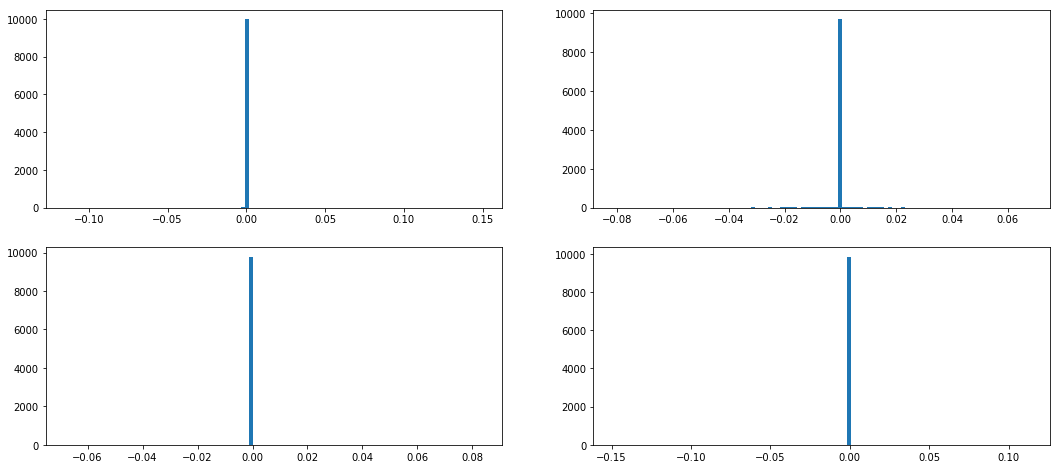

In [9]:
plt.figure(figsize=(18,8))
important_keggs = []
thresh = 0.05
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(LR.coef_[i,:], bins=100)
    important_keggs.append(np.where(LR.coef_[i,:] > thresh)[0])

As we we can from the histograms, most of the weights for the KEGGs are 0 and hence lasso is indeed finding sparse solutions. 

We only consider weights that are strictly positive since the interperation of a postive weight is an increase in the log-odds of the cohort with increase in the abundance of the corresponding KEGG. 

Since we have 4 models, we take the *unioin* of the important KEGGs and treat this collection of KEGGs as the important KEGGs in discriminating between different cohorts. 

In [10]:
discriminating_keggs = np.array(list(set([kegg for keggs in important_keggs for kegg in keggs])))

print("Number of important KEGGs", len(discriminating_keggs))

Number of important KEGGs 30


The number of important KEGGs is significantly less than the original ~10K KEGGs we started out with. We next visualize the cluster heatmap for only these KEGGs

In [11]:
df_subset = df.iloc[discriminating_keggs,:]

total_abund = np.sum(df_subset.iloc[:,2:])

df_subset_normalized = df_subset.copy()
df_subset_normalized.iloc[:,2:] = df_subset_normalized.iloc[:,2:]/total_abund

np.min(df_subset_normalized.iloc[:,2:].values[df_subset_normalized.iloc[:,2:].values>0])

0.00011311548578017775

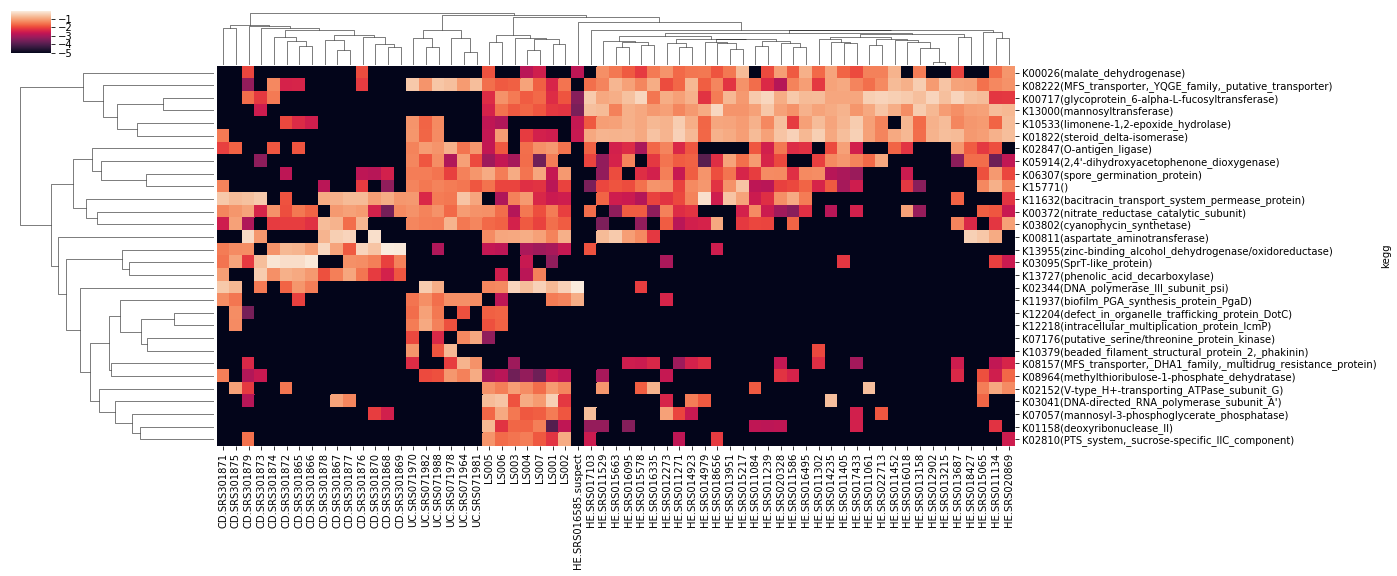

In [12]:
sns.clustermap(np.log10(1e-5+df_subset_normalized.iloc[:,2:]),
               figsize=(18, 8));

As we can see from above, reducing the number of KEGGs to the KEGGs that Lasso has found has significantly improved the cluseting. 

However, there are still an enromous number of KEGGs to consider and the clustering algorithm still fails on two HE subjects in the far left by the LS cohorts. 

# Part 2: Pairwise Logistic Regression

We next prepare the data so that they are pairwise comparisons of each sample and apply lass logistic regression to find the most important KEGGs that discriminate that either the samples are in the same cohort or not. We again use cross validation to select the penalty term. We select the important KEGGs as those that have a positive weight. 

The interpertation here is that a positive weight suggests that increasing this KEGG from one subject compared to another  (since we are doing pairwise comparisons) increases the log-odds of the KEGG determining of the the sample ratio are *not* in the same cohort. 


In this caes the data matrix has 1953 rows and 10K columns whereas before there were only 63 rows. We posit that the solution set we obtain here will be more sparse. 

In [13]:
def pairwise_diffs(np_arr):
    pairwise_indexes = list(itertools.combinations(list(range(np_arr.shape[0])), 2))    
    np_diffs = np.array([np.abs(np_arr[i,:] - np_arr[j,:]) for i, j in pairwise_indexes])
    return np_diffs

def get_sparse_set(input_arr, target_arr, laplace_scale):
    X_diffs = pairwise_diffs(np.log10(input_arr + laplace_scale))

    y_diffs = pairwise_diffs(target_arr[:, np.newaxis]).squeeze()
    y_diffs[y_diffs != 0] = 1
    
    LR = LogisticRegressionCV(Cs = np.logspace(-4, 2, 25), penalty="l1",
                              n_jobs=-2, solver = "liblinear")

    LR.fit(X_diffs, y_diffs)
    
    return LR

In [14]:
%%time

LR_all = get_sparse_set(X, y, laplace_scale)


CPU times: user 1.85 s, sys: 453 ms, total: 2.31 s
Wall time: 18.3 s


In [15]:
LR_all.C_

array([0.00562341])

In [16]:
LR_all.coef_.squeeze().shape

(10012,)

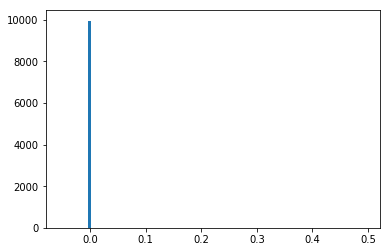

In [17]:
plt.hist(LR_all.coef_.squeeze(), bins=100);

In [18]:
thresh = 0
print(len(np.where(LR_all.coef_ > thresh)[1]))

10


We notice that the number of important KEGGs has been *significantly* reduced in this case; that is, we have a much sparser solution set.  

We next visualize these KEGGs with the clustered heatmap. 

In [19]:
discriminating_keggs = np.where(LR_all.coef_ > thresh)[1]

df_subset = df.iloc[discriminating_keggs,:]

total_abund = np.sum(df_subset.iloc[:,2:])

df_subset_normalized = df_subset.copy()
df_subset_normalized.iloc[:,2:] = df_subset_normalized.iloc[:,2:]/total_abund

np.min(df_subset_normalized.iloc[:,2:].values[df_subset_normalized.iloc[:,2:].values>0])

0.000305214666516735

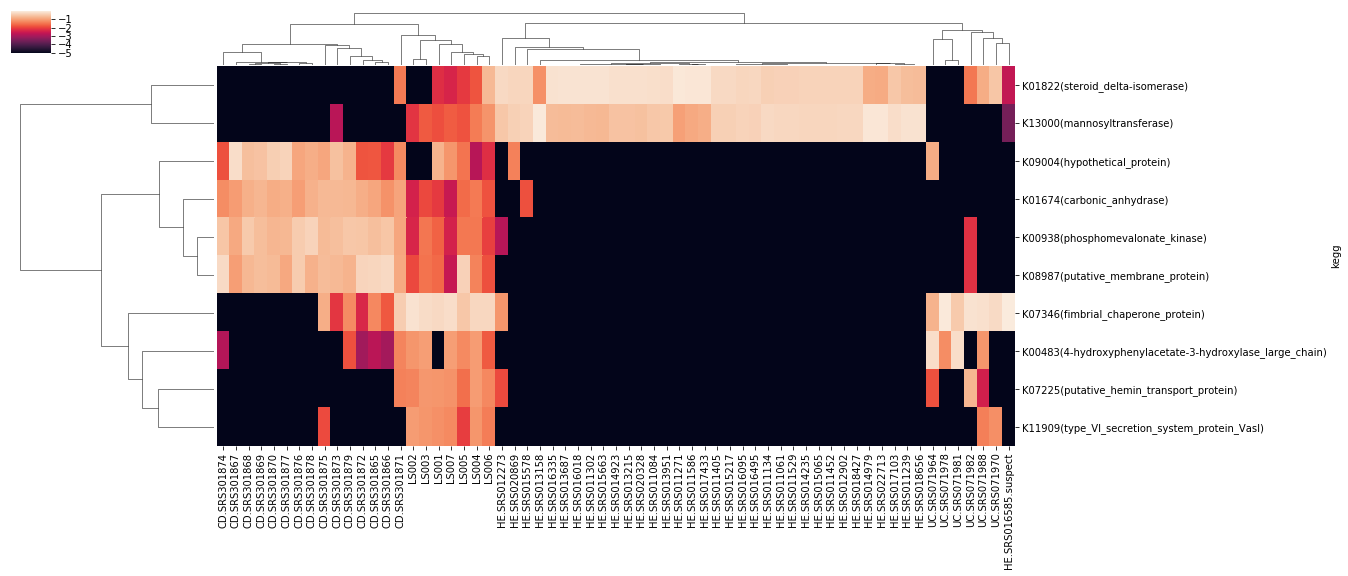

In [20]:
sns.clustermap(np.log10(1e-5+df_subset_normalized.iloc[:,2:]),
               figsize=(18, 8));

We note that the clustering has now significanlty improved from before, and that we have a significantly sparser set of KEGGs to work with 

# Part 2 addendum a: avoiding leakage 

The astute observer may have noticed that our pairwise comparison method may potentially be suffering from data leakage and hence yielding to unreliable estimates of the weight pentaly term.

Here we take etra care in performing a "leave one subject from each cohort out scheme" and estimate the distribution of sparsity for the different sets. 

In [44]:
HE_indx = list(np.where(y==0)[0])
LS_indx = list(np.where(y==1)[0])
CD_indx = list(np.where(y==2)[0])
UC_indx = list(np.where(y==3)[0])

In [45]:
from itertools import cycle

In [46]:
zip_list = zip(HE_indx, cycle(LS_indx), cycle(CD_indx), cycle(UC_indx))

In [47]:
%%time
collection_of_keggs = []
for excluse_indx in zip_list:
    print(excluse_indx)
    X_LOO= np.delete(X, excluse_indx, axis = 0)
    y_LOO = np.delete(y, excluse_indx, axis = 0)
    LR_loo = get_sparse_set(X_LOO, y_LOO, laplace_scale)
    print(len(np.where(LR_loo.coef_ > 0)[1]))
    collection_of_keggs.append(np.where(LR_loo.coef_ > 0)[1])

(28, 0, 7, 22)
8
(29, 1, 8, 23)
19
(30, 2, 9, 24)
16
(31, 3, 10, 25)
8
(32, 4, 11, 26)
5
(33, 5, 12, 27)
10
(34, 6, 13, 22)
8
(35, 0, 14, 23)
12
(36, 1, 15, 24)
9
(37, 2, 16, 25)
8
(38, 3, 17, 26)
6
(39, 4, 18, 27)
9
(40, 5, 19, 22)
8
(41, 6, 20, 23)
12
(42, 0, 21, 24)
10
(43, 1, 7, 25)
8
(44, 2, 8, 26)
9
(45, 3, 9, 27)
10
(46, 4, 10, 22)
9
(47, 5, 11, 23)
12
(48, 6, 12, 24)
9
(49, 0, 13, 25)
36
(50, 1, 14, 26)
6
(51, 2, 15, 27)
9
(52, 3, 16, 22)
9
(53, 4, 17, 23)
18
(54, 5, 18, 24)
12
(55, 6, 19, 25)
9
(56, 0, 20, 26)
5
(57, 1, 21, 27)
11
(58, 2, 7, 22)
9
(59, 3, 8, 23)
10
(60, 4, 9, 24)
14
(61, 5, 10, 25)
9
(62, 6, 11, 26)
23
CPU times: user 54.4 s, sys: 14 s, total: 1min 8s
Wall time: 8min 25s


We notice that for each differnt "fold", we have a different number of important KEGGs that have been discovered. We take the union of all these KEGGs to get the unique count of all important KEGGs from all folds

In [48]:
important_unleaked_keggs = np.array(list(set([kegg for keggs in collection_of_keggs for kegg in keggs])))

print("The number of KEGGs is", len(important_unleaked_keggs))

The number of KEGGs is 54


This is still significantly smaller and more sparase than the previous solution. 

We next investate how frequetly each of these KEGGs are classified as "important" in the different folds. That is, we ciount how often each KEGG is important in each fold. 

In [49]:
collection_of_keggs_list = [kegg for keggs in collection_of_keggs for kegg in keggs]

from collections import Counter

Counter(collection_of_keggs_list).most_common()

[(5962, 35),
 (7730, 35),
 (8369, 35),
 (737, 31),
 (1322, 30),
 (376, 28),
 (1446, 23),
 (4921, 23),
 (5979, 22),
 (5033, 17),
 (3257, 11),
 (7991, 8),
 (9544, 8),
 (1229, 6),
 (3148, 6),
 (1779, 5),
 (1640, 5),
 (7849, 5),
 (3275, 4),
 (2182, 4),
 (9171, 3),
 (7064, 2),
 (5150, 2),
 (8992, 2),
 (2752, 2),
 (3571, 2),
 (4215, 2),
 (4693, 2),
 (6278, 2),
 (2139, 1),
 (8578, 1),
 (6810, 1),
 (8237, 1),
 (554, 1),
 (676, 1),
 (955, 1),
 (1777, 1),
 (1852, 1),
 (2001, 1),
 (2554, 1),
 (3555, 1),
 (5038, 1),
 (7219, 1),
 (7463, 1),
 (7877, 1),
 (7885, 1),
 (8538, 1),
 (8648, 1),
 (9526, 1),
 (215, 1),
 (674, 1),
 (2669, 1),
 (3274, 1),
 (7108, 1)]

We note that out of the all the KEGGs, a smaller subset occur in multiple folds 

Let's look at these KEGGs:

In [77]:
important_keggs = [kegg for kegg, count in Counter(collection_of_keggs_list).most_common() if count >= 7]

In [78]:
df_subset = df.iloc[np.array(important_keggs),:]

total_abund = np.sum(df_subset.iloc[:,2:])

total_abund.min()

1.0096147344324909e-05

In [79]:
df_subset_normalized = df_subset.copy()
df_subset_normalized.iloc[:,2:] = df_subset_normalized.iloc[:,2:]/(total_abund)

np.min(df_subset_normalized.iloc[:,2:].values[df_subset_normalized.iloc[:,2:].values>0])

0.0002589268817005009

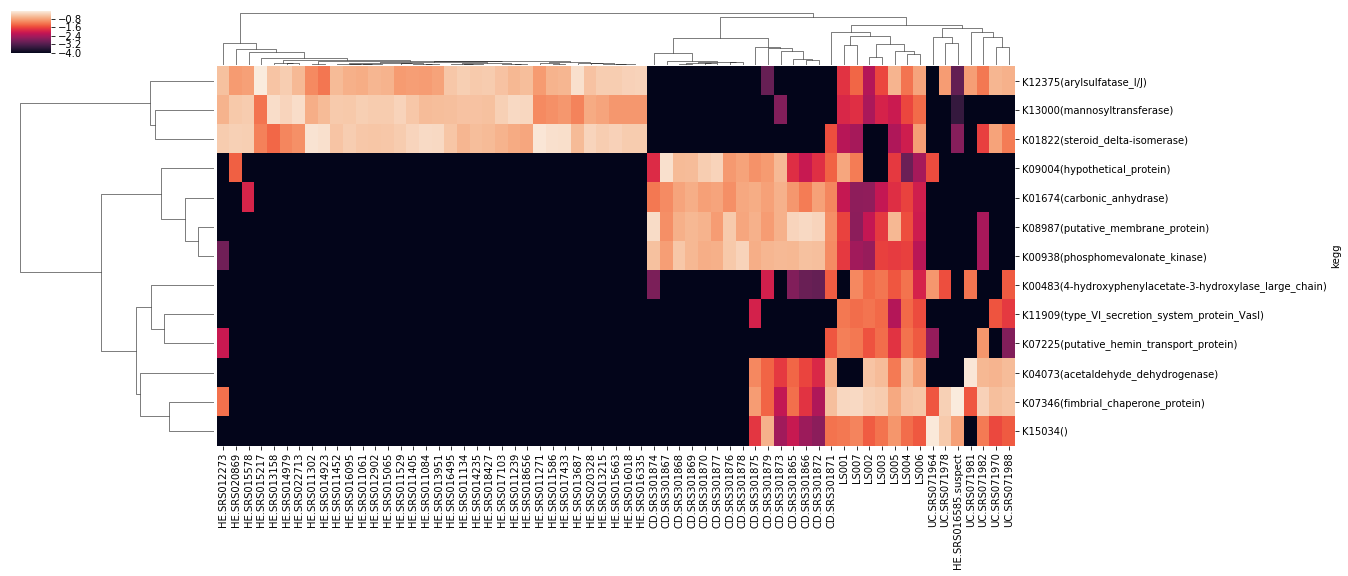

In [80]:
sns.clustermap(np.log10(1e-4+df_subset_normalized.iloc[:,2:]),
               figsize=(18, 8));

We agains see near perfect separation between the different cohorts but using significantly fewer KEGGs. 

In [95]:
for HE_i in HE

(13, 65)

## Part 2 addendum b

In [ ]:
def pairwise_diffs(np_arr):
    pairwise_indexes = list(itertools.combinations(list(range(np_arr.shape[0])), 2))    
    np_diffs = np.array([np.abs(np_arr[i,:] - np_arr[j,:]) for i, j in pairwise_indexes])
    return np_diffs

def get_sparse_set(input_arr, target_arr, laplace_scale):
    X_diffs = pairwise_diffs(np.log10(input_arr + laplace_scale))

    y_diffs = pairwise_diffs(target_arr[:, np.newaxis]).squeeze()
    y_diffs[y_diffs != 0] = 1
    
    LR = LogisticRegressionCV(Cs = np.logspace(-4, 2, 25), penalty="l1",
                              n_jobs=-2, solver = "liblinear")

    LR.fit(X_diffs, y_diffs)
    
    return LR

In [28]:
from sklearn.base import BaseEstimator, ClassifierMixin
class PairwiseLR(BaseEstimator, ClassifierMixin):  
    """An example of classifier"""
    def __init__(self, laplace_scale, **kwargs):
        self.laplace_scale = laplace_scale
        self.LR = LogisticRegressionCV(**kwargs)
    
    def _pairwise_diffs(self, np_arr):
        pairwise_indexes = list(itertools.combinations(list(range(np_arr.shape[0])), 2))    
        np_diffs = np.array([np.abs(np_arr[i,:] - np_arr[j,:]) for i, j in pairwise_indexes])
        return np_diffs

    def fit(self, X, y):
        X_diffs = pairwise_diffs(np.log10(X + self.laplace_scale))

        y_diffs = pairwise_diffs(y[:, np.newaxis]).squeeze()
        y_diffs[y_diffs != 0] = 1        
        
        
        self.LR.fit(X_diffs, y_diffs)
        
        return self

    def predict(self, X, y=None):
        X_diffs = pairwise_diffs(np.log10(X + self.laplace_scale))
        return LR.predict(X_diffs)


In [30]:
prLR = PairwiseLR(laplace_scale, Cs = np.logspace(-4, 2, 25), penalty="l1",
                                       n_jobs=-2, solver = "liblinear")

In [31]:
prLR.fit(X,y)

Process ForkPoolWorker-18:
Process ForkPoolWorker-24:
Process ForkPoolWorker-23:
Process ForkPoolWorker-19:
Process ForkPoolWorker-22:
Process ForkPoolWorker-20:
Process ForkPoolWorker-21:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py",

KeyboardInterrupt: 

In [32]:
from sklearn.ensemble import BaggingClassifier

In [35]:
bg = BaggingClassifier(PairwiseLR(laplace_scale, Cs = np.logspace(-4, 2, 5), penalty="l1",
                                       n_jobs=-2, solver = "liblinear"), n_estimators=10)

In [34]:
X.shape

(63, 10012)

In [36]:
bg.fit(X, y)

BaggingClassifier(base_estimator=PairwiseLR(laplace_scale=1e-09),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [41]:
bg.estimators_[0].LR.coef_.shape

(1, 10012)

## LOO

In [88]:
%%time
collection_of_keggs = []
for HE_i in HE_indx:
    for LS_i in LS_indx:
        for CD_i in CD_indx:
            for UC_i in UC_indx:
                excluse_indx = (HE_i, LS_i, CD_i, UC_i)
                X_LOO= np.delete(X, excluse_indx, axis = 0)
                y_LOO = np.delete(y, excluse_indx, axis = 0)
                LR_loo = get_sparse_set(X_LOO, y_LOO, laplace_scale)
                collection_of_keggs.append(np.where(LR_loo.coef_ > 0)[1])

KeyboardInterrupt: 

In [89]:
len(collection_of_keggs)

2622

In [90]:
important_unleaked_keggs = np.array(list(set([kegg for keggs in collection_of_keggs for kegg in keggs])))

print("The number of KEGGs is", len(important_unleaked_keggs))

The number of KEGGs is 136


In [95]:
collection_of_keggs_list = [kegg for keggs in collection_of_keggs for kegg in keggs]

from collections import Counter

Counter(collection_of_keggs_list).most_common()[:30]

[(5962, 2622),
 (8369, 2622),
 (7730, 2572),
 (1322, 2187),
 (737, 2109),
 (376, 2085),
 (5979, 1713),
 (1446, 1704),
 (4921, 1611),
 (5033, 1222),
 (3257, 947),
 (9544, 446),
 (1229, 435),
 (7991, 424),
 (3148, 386),
 (7849, 359),
 (1640, 285),
 (9171, 180),
 (5150, 155),
 (8992, 145),
 (8237, 121),
 (3275, 112),
 (1779, 106),
 (7877, 95),
 (2182, 70),
 (1916, 69),
 (1777, 68),
 (2139, 64),
 (7064, 53),
 (1852, 40)]

In [96]:
important_keggs = [kegg for kegg, count in Counter(collection_of_keggs_list).most_common() if count >= 100]

In [97]:
df_subset = df.iloc[np.array(important_keggs),:]

total_abund = np.sum(df_subset.iloc[:,2:])

total_abund.min()

5.259069635324254e-05

In [98]:
df_subset_normalized = df_subset.copy()
df_subset_normalized.iloc[:,2:] = df_subset_normalized.iloc[:,2:]/(total_abund)

np.min(df_subset_normalized.iloc[:,2:].values[df_subset_normalized.iloc[:,2:].values>0])

0.00010251767205993238

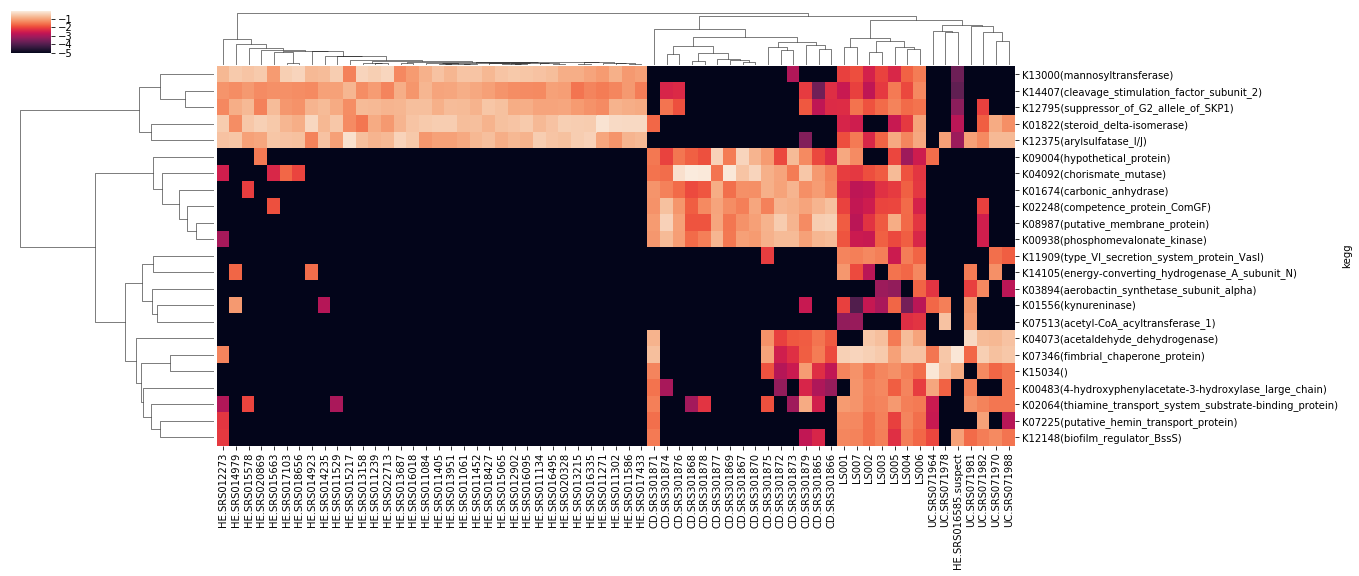

In [100]:
sns.clustermap(np.log10(1e-5+df_subset_normalized.iloc[:,2:]),
               figsize=(18, 8));